# OpenCV day4

### 차영상

영상에서 영상을 빼면 두 영상의 차이, 변화를 알 수 있다.

##### diff = cv2.absdiff(img1, img2)
* img1, img2 : 입력 영상
* diff : 두 영상의 차의 절대 값 반환

In [7]:
import numpy as np, cv2

# 필요한 이미지 읽고 그레이 스케일로 변환
img1 = cv2.imread('./img/robot_arm1.jpg')
img2 = cv2.imread('./img/robot_arm2.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 두 영상의 절대 값 차 연산
diff = cv2.absdiff(img1_gray, img2_gray)

# 차 영상을 극대화하기 위해 스레시홀드 처리 및 컬러로 변환
ret, diff = cv2.threshold(diff, 1, 255, cv2.THRESH_BINARY)
diff_red = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
diff_red[:,:,2]=0

# 두번째 이미지에 변화한 부분 표시
spot = cv2.bitwise_xor(img2, diff_red)

cv2.imshow('img1', img1)
cv2.imshow('img2', img2)
cv2.imshow('diff', diff)
cv2.imshow('spot', spot)
cv2.waitKey()
cv2.destroyAllWindows()
    

### 이미지 합성과 마스킹

In [9]:
import numpy as np, cv2

# 합성에 사용할 영상 읽기
img_fg = cv2.imread('./img/opencv_logo.png', cv2.IMREAD_UNCHANGED)
img_bg = cv2.imread('./img/girl.jpg')

# 알파 채널을 이용해서마스크와 역마스크 생성
_, mask = cv2.threshold(img_fg[:,:,3], 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# 전경 영상 크기로 배경 영상에서 ROI 잘라내기
img_fg = cv2.cvtColor(img_fg, cv2.COLOR_BGRA2BGR)
h, w = img_fg.shape[:2]
roi = img_bg[10:10+h, 10:10+w]

# 마스크 이용해서 오려내기
masked_fg = cv2.bitwise_and(img_fg, img_fg, mask=mask)
masked_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

# 이미지 합성
added = masked_fg + masked_bg
img_bg[10:10+h, 10:10+w] = added

cv2.imshow('mask', mask)
cv2.imshow('mask_inv', mask_inv)
cv2.imshow('masked_fg', masked_fg)
cv2.imshow('masked_bg', masked_bg)
cv2.imshow('added', added)
cv2.imshow('result', img_bg)
cv2.waitKey()
cv2.destroyAllWindows()

### 색상의 범위로 마스크  생성

##### dst = cv2.inRange(img, from, to) : 범위에 속하지 않은 픽셀 판단
* img = 입력 영상
* from : 범위의 시작 배열
* to : 범위의 끝 배열
* dsr : img가 from ~ to 에 포함되면 255, 아니면 0을 픽셀 값으로 하는 배열

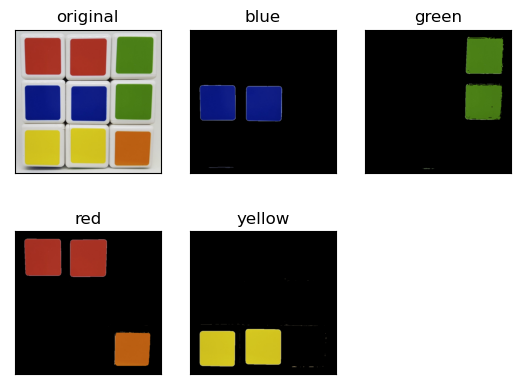

In [10]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# 큐브 이미지를 읽어서 HSV 로 변환
img = cv2.imread('./img/cube.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 색상별로 영역 지정
blue1 = np.array([90, 50, 50])
blue2 = np.array([120, 255, 255])
green1 = np.array([45, 50, 50])
green2 = np.array([75, 255, 255])
red1 = np.array([0,50,50])
red2 = np.array([15,255,255])
red3 = np.array([165,50,50])
red4 = np.array([180,255,255])
yellow1 = np.array([20,50,50])
yellow2 = np.array([35,255,255])

# 색상에 따른 마스크 생성
mask_blue = cv2.inRange(hsv, blue1, blue2)
mask_green = cv2.inRange(hsv, green1, green2)
mask_red = cv2.inRange(hsv, red1, red2)
mask_red2 = cv2.inRange(hsv, red3, red4)
mask_yellow = cv2.inRange(hsv, yellow1, yellow2)

# 색상별 마스크로 색상만 추출
res_blue = cv2.bitwise_and(img, img, mask=mask_blue)
res_green = cv2.bitwise_and(img, img, mask=mask_green)
res_red1 = cv2.bitwise_and(img, img, mask=mask_red)
res_red2 = cv2.bitwise_and(img, img, mask=mask_red2)
res_red = cv2.bitwise_or(res_red1, res_red2)
res_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)

# 결과 출력
imgs = {'original':img, 'blue':res_blue, 'green':res_green,
       'red':res_red, 'yellow':res_yellow}

for i, (k,v) in enumerate(imgs.items()):
    plt.subplot(2,3,i+1)
    plt.title(k)
    plt.imshow(v[:,:,::-1])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [4]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# 크로마키 영상과 합성할 영상 읽기
img1 = cv2.imread('./img/man_chromakey.jpg')
img2 = cv2.imread('./img/street.jpg')

# ROI 선택을 위한 좌표 계산(가운데 위치시키기 위해)
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
x = (width2 - width1)//2
y = height2 - height1
w = x + width1
h = y + height1

# 크로마키 배경 영상에서 크로마키가 있을 법한 영역을 10픽셀 정도로 지정
chromakey = img1[:10, :10, :]
offset = 20

# 크로마키 영역과 영상 전체를 HSV로 변경
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

# 크로마키 영역의 H값에서 offset 만큼 여유를 두어서 범위 지정
# offset값은 여러차례 시도 후 결정
chroma_h = hsv_chroma[:, :, 0]
lower = np.array([chroma_h.min()-offset,100,100])
upper = np.array([chroma_h.max()+offset,255,255])

# 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)
mask_inv = cv2.bitwise_not(mask)
roi = img2[y:h, x:w]
fg = cv2.bitwise_and(img1, img1, mask=mask_inv)
bg = cv2.bitwise_and(roi, roi, mask=mask)
img2[y:h, x:w] = fg + bg

cv2.imshow('chromakey', img1)
cv2.imshow('added', img2)
cv2.waitKey()
cv2.destroyAllWindows()

* 제공하는 함수 사용

##### dst = cv2.seamlessClone(src, dst, mask, coords, flags [ , output ] )
* src : 입력 영상, 일반적으로 전경
* dst : 대상 영상, 일반적으로 배경
* mask : 마스트, src에서 합성하고자 하는 영역은 255, 나머지는 0
* coords : src가 놓여지기 원하는 dst의 중앙좌표
* flags : 합성 방식
  * cv2.NORMAL_CLONE : 입력 원본 유지
  * cv2.MIXED_CLONE : 입력과 대상을 혼합

* output : 합성 결과
* dst : 합성 결과

In [5]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# 합성할 대상 영상 읽기
img1 = cv2.imread('./img/drawing.jpg')
img2 = cv2.imread('./img/my_hand.jpg')

# 마스크 생성, 합성할 이미지 전체 영역을 255로 세팅
mask = np.full_like(img1, 255)

# 합성할 대상 좌표 계산
height, width = img2.shape[:2]
center = (width//2, height//2)

# seamlessClone 으로 합성
normal = cv2.seamlessClone(img1, img2, mask, center, cv2.NORMAL_CLONE)
mixed = cv2.seamlessClone(img1, img2, mask, center, cv2.MIXED_CLONE)

cv2.imshow('normal', normal)
cv2.imshow('mixed', mixed)
cv2.waitKey()
cv2.destroyAllWindows()

## 히스토그램

어떤 항목이 몇개 있는지 세어 놓은것을 그림으로 표시한것.

### 히스토그램 계산과 표시

영상 분야에서는 1~255인 픽셀이 몇개인지 세고 그림으로 표시한 것이다.
픽셀들의 색상이나 명암의 분포를 파악할 수 있다.

##### cv2.calcHist(img, channel, mask, histSize, ranges)

* img : 입력 영상, [img] 처럼 리스트로 표현
* channel : 처리할 채널, 리스트로 표현
  * 1채널 : [0] / 2채널 : [0, 1] / 3채널 : [0, 1, 2]
 
* mask : 마스크에 지정한 픽셀만 히스토그램 계산
* histSize : 계급의 수, 채널 개수에 맞게 리스트로 표현
  * 1채널 : [256] / 2채널 : [256, 256] / 3채널 : [256, 256, 256]
  
* ranges : 각 픽셀이 가질 수 있는 값의 범위, RGB인경우 [0, 256]

(256, 1)
270000.0 (450, 600)


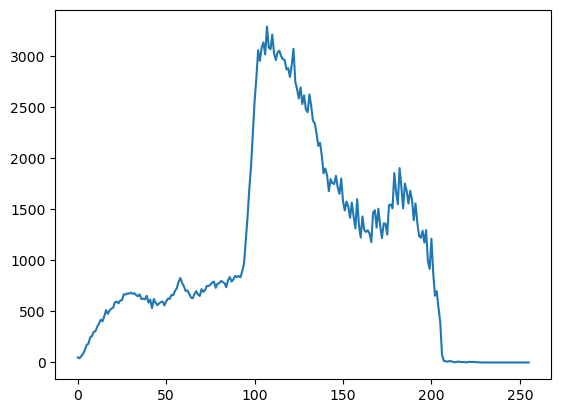

In [6]:
import cv2
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('./img/mountain.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imshow('img', img)


hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)

print(hist.shape)
print(hist.sum(), img.shape)
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()

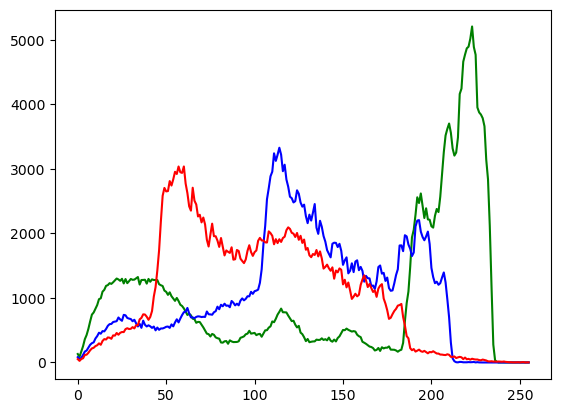

In [1]:
import cv2
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('./img/mountain.jpg')
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

channels = cv2.split(img)
colors = {'b','g','r'}
for (ch, color) in zip (channels, colors):
    hist = cv2.calcHist([ch],[0],None,[256],[0,256])
    plt.plot(hist, color = color)

plt.show()

### 노멀라이즈

픽셀값이 특정 특정 영역에 몰려잇는 경우 화질을 개선하고 영상간의 조건을 같게 만들어 주기위해 사용

##### dst = cv2.normalize(src, dst, alpha, beta, type_flag)
* src : 노멀라이즈 이전 데이터
* dst : 노멀라이즈 이후 데이터
* alpha : 노멀라이즈 구간 1
* beta : 노멀라이즈 구간 2, 구간 노멀라이즈가 아닌 경우 사용 안함
* type_flag : 알고리즘 선택 플래그 상수
  * cv2.NORM_MINMAX : alpha와 beta 구간으로 노멀라이즈
  * cv2.NORM_L1 : 전체 합으로 나누기, alpha = 노멀라이즈 전체 합
  * cv2.NORM_L2 : 단위 벡터(unit vector)로 노멀라이즈
  * cv2.NORM_INF : 최대 값으로 나누기
  

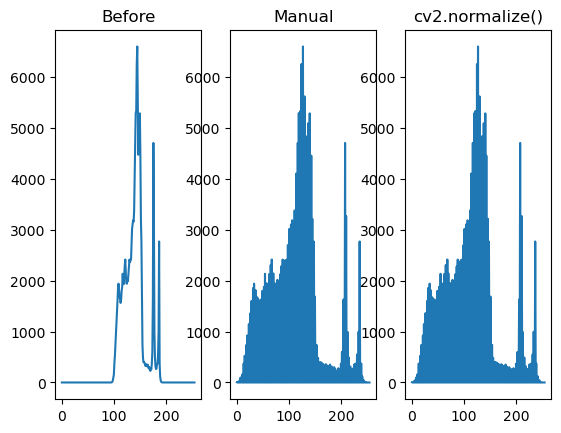

In [3]:
import cv2
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('./img/abnormal.jpg', cv2.IMREAD_GRAYSCALE)

# 직접 연산 정규화
img_f = img.astype(np.float32)
img_norm = ((img_f - img_f.min())*(255)/(img_f.max()-img_f.min()))
img_norm = img_norm.astype(np.uint8)

# opencv api를 이용한 정규화
img_norm2 = cv2.normalize(img,None,0,255,cv2.NORM_MINMAX)

# 히스토그램 계산
hist = cv2.calcHist([img], [0], None, [256], [0,255])
hist_norm = cv2.calcHist([img_norm], [0], None, [256], [0,255])
hist_norm2 = cv2.calcHist([img_norm2], [0], None, [256], [0,255])

cv2.imshow('Before', img)
cv2.imshow('Manual', img_norm)
cv2.imshow('cv2.normalize()', img_norm2)
cv2.waitKey()
cv2.destroyAllWindows()


hists = {'Before':hist, 'Manual':hist_norm, 'cv2.normalize()':hist_norm2}

for i, (k,v) in enumerate(hists.items()):
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.plot(v)
plt.show()

### 이퀄라이즈

노멀라이즈는 집중된 곳에서 떨어진 값에는 효과가 없다.
이퀄라이즈는 히스토그램으로 빈도를 구해서 노멀라이즈 한후 누적값을 전체개수로 나누어 나온 결과를 히스토그램 원래 픽셀에 매핑한다.

##### dst = cv2.eaualizeHist(src[ , dst] )
* src : 대상 이미지, 8비트 1채널
* dst : 결과 이미지

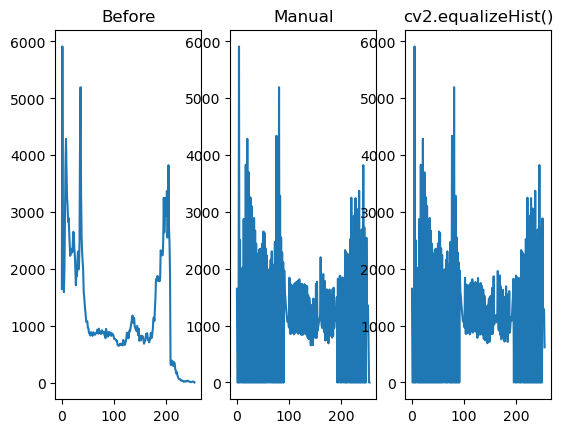

In [6]:
import cv2
import numpy as np
import matplotlib.pylab as plt

img = cv2.imread('./img/yate.jpg', cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape[:2]

# 직접 적용
hist = cv2.calcHist([img], [0], None, [256], [0,256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())/(rows*cols)*255
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]

# opencv api로 적용
img3 = cv2.equalizeHist(img)

# 이퀄라이즈 결과 히스토그램 계산
hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])
hist3 = cv2.calcHist([img3],[0],None,[256],[0,256])

cv2.imshow('Before',img)
cv2.imshow('Manual',img2)
cv2.imshow('cv2.equalizeHist()',img3)
cv2.waitKey()
cv2.destroyAllWindows()

hists = {'Before':hist, 'Manual':hist2, 'cv2.equalizeHist()':hist3}

for i, (k,v) in enumerate(hists.items()):
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.plot(v)
plt.show()

* 컬러이미지에 대해 이퀄라이즈 적용

In [7]:
import numpy as np, cv2

img = cv2.imread('./img/yate.jpg')

img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

img2 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

cv2.imshow('Before', img)
cv2.imshow('After', img2)
cv2.waitKey()
cv2.destroyAllWindows()